### Example finding flares via HEK and then getting GOES/XRS15 data

Note: several ways of doing and plotting this. The following works but there be more "optimal" ways.

Other resources: [Sunpy doc on goes flare list from HEK](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/querying_the_GOES_event_list.html#sphx-glr-generated-gallery-acquiring-data-querying-the-goes-event-list-py) and [Sunpy doc on getting/plotting XRS](https://docs.sunpy.org/en/stable/generated/gallery/acquiring_data/goes_xrs_example.html#sphx-glr-generated-gallery-acquiring-data-goes-xrs-example-py)

* 22-10-21   IGH
* 23-10-21   - Fixed axvline needing a datetime, not a string
* 25-11-21   - Added in info about difference in fluxes from data and catalogue
---

In [1]:
#  Import in the usual stuff
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.time import Time
from astropy.time import TimeDelta
from sunpy.time import parse_time

#  Here just assuming it save to your sunpy/data dir but can of course change
outdir='/Users/iain/sunpy/data/'

In [2]:
# Let's look for all the X-class flares in 2017
trange=a.Time("2017-01-01 00:00","2018-01-01 00:00")
res = Fido.search(trange,a.hek.EventType("FL"),a.hek.FL.GOESCls > "X1.0",a.hek.OBS.Observatory == "GOES")
hekres = res["hek"]

In [3]:
#  Four X-class flares in 2017 and lot's of info in the HEK about them
hekres

gs_thumburl,comment_count,hpc_bbox,frm_humanflag,hgc_coord,event_coordsys,obs_levelnum,hpc_coord,event_npixels,gs_imageurl,ar_polarity,frm_paramset,hrc_coord,event_starttime,ar_mtwilsoncls,event_type,intensmin,fl_fluence,obs_meanwavel,frm_url,skel_chaincode,bound_chaincode,noposition,fl_fluenceunit,active,intensmax,frm_versionnumber,fl_peaktempunit,fl_halphaclass,area_uncert,obs_dataprepurl,hpc_geom,hgc_bbox,intensmedian,chaincodetype,obs_channelid,event_clippedspatial,ar_noaaclass,SOL_standard,event_avg_rating,eventtype,intensunit,hpc_boundcc,event_mapurl,frm_contact,ar_penumbracls,intensmean,bound_ccstartc1,frm_name,area_atdiskcenter,frm_identifier,obs_observatory,event_description,boundbox_c2ur,obs_firstprocessingdate,boundbox_c2ll,frm_institute,hrc_bbox,refs_orig,ar_mcintoshcls,event_maskurl,bound_ccstartc2,gs_movieurl,event_score,skel_startc2,skel_startc1,fl_efoldtime,event_expires,fl_efoldtimeunit,hrc_boundcc,event_probability,intensvar,frm_daterun,event_coordunit,hpc_y,hpc_x,search_instrument,ar_numspots,kb_archivdate,kb_archivist,intenstotal,sum_overlap_scores,hgs_boundcc,intensskew,obs_includesnrt,rasterscan,obs_wavelunit,kb_archivid,search_frm_name,boundbox_c1ur,ar_noaanum,area_atdiskcenteruncert,boundbox_c1ll,event_importance_num_ratings,ar_compactnesscls,skel_curvature,event_testflag,event_c2error,hrc_r,skel_nsteps,hgs_y,obs_title,fl_peakemunit,hgs_x,hcr_checked,frm_specificid,event_title,obs_instrument,event_c1error,revision,hpc_radius,event_endtime,event_importance,event_coord2,event_coord3,event_coord1,search_observatory,area_raw,concept,event_pixelunit,hgc_boundcc,fl_peakflux,hgc_x,hrc_a,event_peaktime,hgc_y,gs_galleryid,fl_goescls,hgs_coord,ar_zurichcls,bound_ccnsteps,intenskurt,event_clippedtemporal,fl_peakfluxunit,fl_peakem,rasterscantype,search_channelid,fl_peaktemp,hgs_bbox,area_unit,obs_lastprocessingdate,refs [2]
str1,str1,str125,str5,str21,str12,object,str29,object,str1,object,str27,str41,Time,str1,str2,object,object,float64,str25,str1,str1,str5,str1,str4,object,object,str1,str1,object,str1,str186,str95,object,str1,str3,str1,str1,str30,object,str1,str1,str1,str1,str23,str1,object,object,str4,object,str4,str4,str1,float64,str1,float64,str61,str110,str1,str1,str1,object,str1,str20,object,object,object,str1,str1,str1,object,object,str19,str7,float64,float64,str4,object,str19,str11,object,str20,str1,object,str1,str1,str2,str66,str4,float64,int64,object,float64,str1,str1,object,str5,int64,float64,object,int64,str1,str1,int64,str4,str1,str1,str4,int64,str1,str19,Time,object,int64,object,int64,str4,object,str5,str1,str1,object,float64,float64,Time,int64,str1,str4,str13,str1,object,object,str1,str1,object,str1,str3,object,str66,str1,str1,object
,0,"POLYGON((508.749012 -224.378094,522.585918 -223.233288,523.716606 -207.039474,509.849808 -208.186056,508.749012 -224.378094))",false,POINT(116.929197 -7),UTC-HGS-TOPO,None,POINT(516.264948 -215.721384),None,,None,"SSWIDL get_gev, ..., ngdc=0",POINT(0.588075322199437 247.322381781107),2017-09-06 08:57:00.000,,FL,None,None,5e-08,http://www.swpc.noaa.gov/,,,false,,true,None,None,,,None,,010300000001000000050000000CFFE9060AD17940EC3026FDBDEE73C00CFFE9060AD17940162AFF5A5E215CC0BA32A836B85B8340162AFF5A5E215CC0BA32A836B85B8340EC3026FDBDEE73C00CFFE9060AD17940EC3026FDBDEE73C0,"POLYGON((116.429197 -7.5,117.429197 -7.5,117.429197 -6.5,116.429197 -6.5,116.429197 -7.5))",None,,XRA,,,SOL2017-09-06T08:57:00L116C097,None,9,,,,SWPC.Webmaster@noaa.gov,,None,None,SWPC,None,SWPC,GOES,,-6.5,,-7.5,"U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center","POLYGON((0.584406 246.200656,0.597268 246.869256,0.591894 248.42976,0.57882 247.788421,0.584406 246.200656))",,,,None,,0.844000000000000083,None,None,None,,,,None,None,2017-09-06T00:00:00,degrees,-215.721384,516.264948,GOES,None,2017-09-06T17:36:04,cheung_mark,None,0.887617077621888351,,None,,,cm,ivo://helio-informatics.org/FL_SWPC_20170906_173603_20170906085700,SWPC,33.5,12673,None,32.5,,,None,false,1,0.588075322199437,None,-7,,,3

In [4]:
# Reduce the table down to just the info we want
shrt_res = hekres["event_starttime", "event_peaktime",
                        "event_endtime", "fl_goescls", "ar_noaanum"]
shrt_res

event_starttime,event_peaktime,event_endtime,fl_goescls,ar_noaanum
Time,Time,Time,str4,int64
2017-09-06 08:57:00.000,2017-09-06 09:10:00.000,2017-09-06 09:17:00.000,X2.2,12673
2017-09-06 11:53:00.000,2017-09-06 12:02:00.000,2017-09-06 12:10:00.000,X9.3,12673
2017-09-07 14:20:00.000,2017-09-07 14:36:00.000,2017-09-07 14:55:00.000,X1.3,12673
2017-09-10 15:35:00.000,2017-09-10 16:06:00.000,2017-09-10 16:31:00.000,X8.2,12673


In [5]:
# Now get the XRS data for the second flare (first missing in G15 data)
# Want data for +/-10 mins of flare, using astopy time to do this (easier sunpy way?)

gtstart=Time(shrt_res[1]["event_starttime"],scale='utc')-TimeDelta(10*60,format='sec')
gtend=Time(shrt_res[1]["event_endtime"],scale='utc')+TimeDelta(10*60,format='sec')
print(gtstart)
print(gtend)

# Search and get the XRS data
tflrange=a.Time(gtstart.iso,gtend.iso)
rg15 = Fido.search(tflrange, a.Instrument("XRS"), a.goes.SatelliteNumber(15))
print(rg15)
fg15 = Fido.fetch(rg15,path=outdir)

2017-09-06 11:43:00.000
2017-09-06 12:20:00.000
Results from 1 Provider:

1 Results from the XRSClient:
Source: https://umbra.nascom.nasa.gov/goes/fits

       Start Time               End Time        Instrument ... Source Provider
----------------------- ----------------------- ---------- ... ------ --------
2017-09-06 00:00:00.000 2017-09-06 23:59:59.999        XRS ...   GOES     NOAA




Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

sci_gxrs-l2-irrad_g15_d20170906_v0-0-0.nc:   0%|          | 0.00/896k [00:00<?, ?B/s]

In [6]:
# Load data file in, truncate to desired time range, extract out time index and data 
fg15=glob.glob(outdir+'*g15*20170906*.nc')
g15 = ts.TimeSeries(fg15, concatenate=True)

tg15=g15.truncate(tflrange.start.iso,tflrange.end.iso)

tg_tims=tg15.index
tg_x05=tg15.quantity("xrsa").value
tg_x18=tg15.quantity("xrsb").value


In [7]:
# What is the peak flux in the GOES data now as data has been reprocessed to remove scaling but catalogue values not changed?
# i.e. https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/GOES_13-15_XRS_Science-Quality_Data_Readme.pdf
max18=max(tg_x18)
new_fl_goescls="X{0:.1f}".format(1e4*max18)
print("New peak flux ",new_fl_goescls)
print("Catalogue peak flux ",shrt_res[1]["fl_goescls"])
print("Ratio old/new (should be ~0.7): ",float(shrt_res[1]["fl_goescls"][1:])/(1e4*max18))

New peak flux  X13.5
Catalogue peak flux  X9.3
Ratio old/new (should be ~0.7):  0.6882066234983945


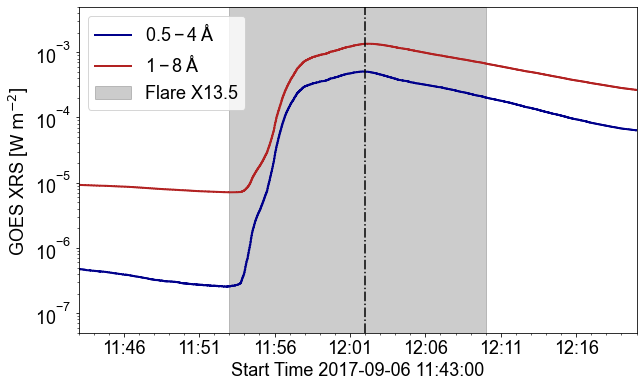

In [8]:
# And then plot it all
tfl=a.Time(shrt_res[1]["event_starttime"],shrt_res[1]["event_endtime"])

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(tg_tims,tg_x05,drawstyle='steps-post',marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')
plt.plot(tg_tims,tg_x18,drawstyle='steps-post',marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')

ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Start Time "+tflrange.start.iso[:-4])
ax.set_yscale("log")
ax.set_ylim([5e-8,5e-3])
ax.set_xlim([tflrange.start.datetime,tflrange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)

# Using sunpy parse_time here to produce datetime version from string
ax.axvline(parse_time(shrt_res[1]["event_peaktime"]).datetime,color='black',ls='-.')
# tfl is a sunpy attrs time range so easy to get datetime out
# ax.axvspan(tfl.start.datetime,tfl.end.datetime,color='black',alpha=0.2, label='Flare '+shrt_res[1]["fl_goescls"])
# Label with the new GOES class
ax.axvspan(tfl.start.datetime,tfl.end.datetime,color='black',alpha=0.2, label='Flare '+new_fl_goescls)


plt.legend()
# plt.tight_layout()
# plt.savefig('xflare.pdf')
plt.show()